<a href="https://colab.research.google.com/github/sadavarterohit/EIBEC3-Diffusion/blob/main/findiff_phily_sector_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install required libaries.

In [1]:
# install required libraries
!pip install sdv # install the synthetic data vault library
"""
The sdv library is a synthetic data generation library.
Here, the authors have used it for ease of tests.

"""

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.8/73.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.4/193.4 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

'\nThe sdv library is a synthetic data generation library.\nHere, the authors have used it for ease of tests.\n\n'

Import required libraries.

In [2]:
!pip install xlrd

In [3]:
# import data science libraries
import pandas as pd
import numpy as np
import math

"""
Math can be ignored becase it is only being used for log, we should use torch.log instead (minor detail)
"""

# import scikit-learn preprocessing
from sklearn.preprocessing import LabelEncoder, QuantileTransformer

# import pytorch libraries
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# import synthetic data vault libraries
from sdv.metadata import SingleTableMetadata
import sdv.evaluation.single_table as sdv_st

# import utility libraries
from tqdm import tqdm
import xlrd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime

# import visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns

Init and set experiment parameters.

In [4]:
# set random seed
seed = 1234

# set dimension of categorical embeddings
cat_emb_dim = 2

"""
cat_emb_dim * number of catergorical variables is the overall size of the categorical embeddings
"""
# set number of neurons per layer
mlp_layers = [8192, 8192, 8192, 8192, 8192, 8192]

# set non-linear activation function
activation = 'lrelu'

# set number of diffusion steps
diffusion_steps = 500

# set diffusion start and end betas
diffusion_beta_start = 1e-4
diffusion_beta_end = 0.02

"""
y = root(beta) * xt-1 + root(1-beta) * noise

The beta is changing either 'linear'ly or 'quad'ratically depending on the scheduler.
"""
# set diffusion scheduler
scheduler = 'linear'

# set number of training epochs
epochs = 500

# set training batch size
batch_size = 512

# set training learning rate
learning_rate = 1e-4

# set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu").type

In [5]:
device

'cuda'

Set random seed values.

In [6]:
# set numpy seed
np.random.seed(seed)

# set pytorch seed
torch.manual_seed(seed)

# set cuda seed
torch.cuda.manual_seed(seed)

## Load, pre-process, and init the UCU Credit Card dataset
The dataset is available under https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients.

In [7]:
# response.content

In [33]:
# set data path
# data_url = 'https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip'

# # download the file
# response = requests.get(data_url)

# # determine the zip file
# zip_file = ZipFile(BytesIO(response.content))

# # extract the zip file
# zip_file.extractall('data')

# read the UCI credit card dataset
train_raw = pd.read_csv('/content/city_payments_sector_label_fy2017.csv')

Inspect the top 10 rows and attribute names of the dataset retreived.

In [34]:
# display top 10 rows
train_raw.head(10)

,Unnamed: 0,fy,fm,check_date,document_no,dept,department_title,char_,character_title,sub_obj,sub_obj_title,vendor_name,doc_ref_no_prefix,doc_ref_no_prefix_definition,contract_number,contract_description,transaction_amount,sector
0,0,2017,10,2017-04-12,CHEK17119771,42,42 COMMERCE,2,02 PURCHASE OF SERVICES,231,OVERTIME MEALS 0231,EAT AT JOE'S,PVXX,payment voucher,NaN,NaN,66.82,Accommodation and Food Services
1,1,2017,12,2017-06-09,ACHD17177233,26,26 LICENSES & INSPECTIONS,2,02 PURCHASE OF SERVICES,211,TRANSPORTATION 0211,L & I Â TRAVEL IMPREST FUND,PVXX,payment voucher,NaN,NaN,127.33,Unknown
2,2,2017,5,2016-11-25,CHEK17063736,44,44 LAW,2,02 PURCHASE OF SERVICES,258,COURT REPORTERS 0258,"MARLENE BELL REPORTING, INC.",PVXX,payment voucher,NaN,NaN,454.20,"Professional, Scientific, and Technical Services"
3,3,2017,1,2016-07-07,CHEK17000247,11,11 POLICE,2,02 PURCHASE OF SERVICES,260,REPAIR AND MAINTENANCE CHARGES 0260,RICOH AMERICAS CORPORATION,VCXX,procurement,NaN,NaN,50.00,Information
4,4,2017,1,2016-07-08,ACHD17000233,23,23 PRISONS,3,03 MATERIALS AND SUPPLIES,313,FOOD 0313,PHILADELPHIA PRISONS,PCXX,petty cash,NaN,NaN,71.92,Public Administration (government agencies and...
5,5,2017,1,2016-07-08,ACHD17000235,23,23 PRISONS,3,03 MATERIALS AND SUPPLIES,313,FOOD 0313,PHILADELPHIA PRISONS,PCXX,petty cash,NaN,NaN,109.61,Public Administration (government agencies and...
6,6,2017,1,2016-07-07,CHEK17003248,22,22 HUMAN SERVICES,3,03 MATERIALS AND SUPPLIES,317,HOSPITAL AND LABORATORY 0317,BANDY COMPANY,VCXX,procurement,150234,Supplies for Child Care Room,1.55,Wholesale Trade
7,7,2017,1,2016-07-07,CHEK17003564,28,28 WATER,2,02 PURCHASE OF SERVICES,260,REPAIR AND MAINTENANCE CHARGES 0260,OMEGA RESTORATION INC,PVXX,payment voucher,NaN,NaN,3085.36,Construction
8,8,2017,1,2016-07-07,CHEK17003787,44,44 LAW,2,02 PURCHASE OF SERVICES,258,COURT REPORTERS 0258,BISNOW AND JOSEPH LLC,PVXX,payment voucher,NaN,NaN,235.50,"Professional, Scientific, and Technical Services"
9,9,2017,1,2016-07-08,ACHD17000619,48,48 MAYOR-OFFICE OF THE INSPECTOR GENERAL,2,02 PURCHASE OF SERVICES,211,TRANSPORTATION 0211,MAYOR'S OFFICE/INSP GEN'L IMPREST ACCT,PVXX,payment voucher,NaN,NaN,43.00,Public Administration (government agencies and...


In [35]:
# display attribute names
train_raw.columns

Index(['Unnamed: 0', 'fy', 'fm', 'check_date', 'document_no', 'dept',
       'department_title', 'char_', 'character_title', 'sub_obj',
       'sub_obj_title', 'vendor_name', 'doc_ref_no_prefix',
       'doc_ref_no_prefix_definition', 'contract_number',
       'contract_description', 'transaction_amount', 'sector'],
      dtype='object')

Set numerical and categorical dataset attributes.

In [36]:

# determine categorical attributes
cat_attrs = ['fm', 'department_title','character_title', 'sub_obj_title', 'sector']



# determine numerical attributes
num_attrs = ['transaction_amount']

In [37]:
# List of all relevant columns to check for NaNs
columns_to_check = cat_attrs + num_attrs + ['doc_ref_no_prefix_definition']

# Drop rows with NaNs in any of those columns
train_cleaned = train_raw.dropna(subset=columns_to_check)

In [38]:
# Sample 100,000 rows from the cleaned dataset
train_raw = train_cleaned.sample(n=100000, random_state=42)

Pre-process dataset attributes.

In [39]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(train_raw['doc_ref_no_prefix_definition'])

# Step 2: Convert to torch.LongTensor
label = torch.LongTensor(label_encoded)

In [40]:
train_raw

,Unnamed: 0,fy,fm,check_date,document_no,dept,department_title,char_,character_title,sub_obj,sub_obj_title,vendor_name,doc_ref_no_prefix,doc_ref_no_prefix_definition,contract_number,contract_description,transaction_amount,sector
224148,224148,2017,9,2017-03-16,CHEK17108391,20,20 PUBLIC PROPERTY,2,02 PURCHASE OF SERVICES,260,REPAIR AND MAINTENANCE CHARGES 0260,DEVINE BROTHERS INC,PVXX,payment voucher,NaN,NaN,31071.60,Construction
146107,146107,2017,5,2016-11-10,CHEK17056823,10,10 MANAGING DIRECTOR,2,02 PURCHASE OF SERVICES,253,LEGAL SERVICES 0253,SHARON K. WALLIS,PVAT,court appointed attorneys,NaN,NaN,300.00,"Professional, Scientific, and Technical Services"
172800,172800,2017,6,2016-12-22,CHEK17074927,10,10 MANAGING DIRECTOR,2,02 PURCHASE OF SERVICES,253,LEGAL SERVICES 0253,CRAIG B. SOKOLOW,PVAT,court appointed attorneys,NaN,NaN,250.00,"Professional, Scientific, and Technical Services"
23366,23366,2017,10,2017-04-12,CHEK17117583,25,25 FLEET MANAGEMENT,2,02 PURCHASE OF SERVICES,285,RENTS 0285,NESTLE WATERS NORTH AMERICA INC,VCXX,procurement,140174,"Bottled Drinking Water and Distilled Water,",1.99,Wholesale Trade
90622,90622,2017,2,2016-08-18,CHEK17018929,16,16 RECREATION,3,03 MATERIALS AND SUPPLIES,307,CHEMICALS AND GASES 0307,BUCKMANS INC,VCXX,procurement,160125,Water Treatment Chemicals,352.00,Retail Trade
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149627,149627,2017,5,2016-11-14,ACHD17066108,69,69 DISTRICT ATTORNEY,2,02 PURCHASE OF SERVICES,260,REPAIR AND MAINTENANCE CHARGES 0260,XEROX CORPORATION,VCXX,procurement,160025,"Purchase, Lease/Purchase, Lease and Maintenanc...",35.00,Information
221915,221915,2017,9,2017-03-10,ACHD17132994,42,42 COMMERCE,2,02 PURCHASE OF SERVICES,253,LEGAL SERVICES 0253,ARCHER & GREINER,PVMD,professional services,1120500,Bock/G&T/Daroff-Airpt,14658.65,"Professional, Scientific, and Technical Services"
203153,203153,2017,8,2017-02-09,CHEK17094986,28,28 WATER,2,02 PURCHASE OF SERVICES,264,ABATEMENT OF OTHER NUISANCES 0264,"JACK EDMONDSON, INC.",VCXX,procurement,170018,Plumbing Repairs Program,3580.00,Construction
104735,104735,2017,3,2016-09-08,CHEK17029551,25,25 FLEET MANAGEMENT,3,03 MATERIALS AND SUPPLIES,328,MOTOR VEHICLE PARTS AND ACCESSORIES 0328,IEH AUTO PARTS LLC,PVFM,auto parts,NaN,NaN,1526.86,Wholesale Trade


In [41]:
# remove underscore in column names for correct inverse decoding
#train_raw.columns = [col.replace('_', '') for col in train_raw.columns]

# convert categorical attributes to string
train_raw[cat_attrs] = train_raw[cat_attrs].astype(str)

# iterate over categorical attributes
for cat_attr in cat_attrs:

    # add col name to every categorical entry to make them distinguishable for embedding
    train_raw[cat_attr] = cat_attr + '_' + train_raw[cat_attr].astype('str')

Set dataset label.

Determine the training data.

In [42]:
# merge selected categorical and numerical attributes
train = train_raw[[*cat_attrs, *num_attrs]]

Transform the numerical attributes.

In [44]:
'''
Quantile Transformation chosen over Standard Scaler/ Power Method.
Fidelity score is the best when Quantile Transformation is chosen, according to the paper Section 6
'''

# init the quantile transformation
num_scaler = QuantileTransformer(output_distribution='normal', random_state=seed)

# fit transformation to numerical attributes
num_scaler.fit(train[num_attrs])

# transform numerical attributes
train_num_scaled = num_scaler.transform(train[num_attrs])

Transform the categorical attributes.

In [45]:
'''
embedding chosen to avoid high demensionality of data (compared to one-hot encoding)
note: does not preserve ordinal nature of data (LabelEncoder assigns random numbers to each cat(vocab))
may not make sense for Age, Education, PAYN

as mentioned earlier, ordinal encoding should work better than label encoder, but since we are generating embeddings, can experiment with one hot as well.
'''

# get vocabulary of categorical attributes
vocabulary_classes = np.unique(train[cat_attrs])

# init categorical attribute encoder
label_encoder = LabelEncoder()

# fit encoder to categorical attributes
label_encoder.fit(vocabulary_classes)

# transform categorical attributes
train_cat_scaled = train[cat_attrs].apply(label_encoder.transform)

# collect unique values of each categorical attribute
vocab_per_attr = {cat_attr: set(train_cat_scaled[cat_attr]) for cat_attr in cat_attrs}

In [46]:
train_cat_scaled

,fm,department_title,character_title,sub_obj_title,sector
224148,74,20,0,272,80
146107,70,12,0,182,89
172800,71,12,0,182,89
23366,64,24,0,271,98
90622,67,18,1,120,94
...,...,...,...,...,...
149627,70,60,0,272,84
221915,74,37,0,182,89
203153,73,27,0,100,80
104735,68,24,1,193,98


Convert numerical and categorical attributes as well as the labels to tensors.

In [47]:
label

tensor([6, 2, 2,  ..., 8, 1, 8])

In [48]:

# convert numerical attributes
train_num_torch = torch.FloatTensor(train_num_scaled)

# convert categorical attributes
train_cat_torch = torch.LongTensor(train_cat_scaled.values)

# convert label
label_torch = torch.LongTensor(label)

In [49]:
label

tensor([6, 2, 2,  ..., 8, 1, 8])

Convert dataset to tensor dataset.

In [50]:
# init tensor dataset
train_set = TensorDataset(
    train_cat_torch, # categorical attributes
    train_num_torch, # numerical attributes
    label_torch # dataset labels
)

Init the data loader.

In [51]:
# init the data loader
dataloader = DataLoader(
    dataset=train_set, # training dataset
    batch_size=batch_size, # training batch size
    num_workers=0, # number of workers
    shuffle=True # shuffle training data
)

## Implement the FinDiff model

Implement the FinDiff backbone model.

In [ ]:
# define base feedforward network
class BaseNetwork(nn.Module):

    # define base network constructor
    def __init__(self, hidden_size, activation='lrelu'):

        # call super calass constructor
        super(BaseNetwork, self).__init__()
        """
        layers defined by default as [1024, 1024, 1024]
        """

        # init
        self.layers = self.init_layers(hidden_size)

        # case: lrelu activation
        if activation == 'lrelu':

            # set lrelu activation
            self.activation = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        # case: relu activation
        elif activation == 'relu':

            # set relu activation
            self.activation = nn.ReLU(inplace=True)

        # case: tanh activation
        elif activation == 'tanh':

            # set tanh activation
            self.activation = nn.Tanh()

        # case: sigmoid activation
        else:

            # set sigmoid activation
            self.activation = nn.Sigmoid()

    # define layer initialization
    def init_layers(self, layer_dimensions):

        # init layers
        layers = []

        # iterate over layer dimensions
        for i in range(len(layer_dimensions)-1):

            # init linear layer
            layer = nn.Linear(layer_dimensions[i], layer_dimensions[i + 1], bias=True)

            # init linear layer weights
            nn.init.xavier_uniform_(layer.weight)
            """
            https://www.geeksforgeeks.org/xavier-initialization/
            smart way to initialise to get fastest convergence
            """

            # init linear layer bias
            nn.init.constant_(layer.bias, 0.0)

            # collecet linear layer
            layers.append(layer)

            # register linear layer parameters
            self.add_module('linear_' + str(i), layer)

        # return layers
        return layers

    # define forward pass
    def forward(self, x):

        # iterate over layers
        for i in range(len(self.layers)):

            # run layer forward pass
            x = self.activation(self.layers[i](x))

        # return forward pass result
        return x

Implement the FinDiff model synthesizer.

In [ ]:
# define MLP synthesizer network
class MLPSynthesizer(nn.Module):

    # define MLP synthesizer network constructor
    def __init__(
            self,
            d_in: int,
            hidden_layers: list,
            activation: str='lrelu', # layer activation
            dim_t: int=64,
            n_cat_tokens=None, # number of categorical tokens
            n_cat_emb=None, # number of categorical dimensions
            embedding=None, #pretrained embedding
            embedding_learned=True,
            n_classes=None
        ):

        # call super class constructor
        super(MLPSynthesizer, self).__init__()

        # init ???
        self.dim_t = dim_t

        # init synthesizer base feed forward network
        self.backbone = BaseNetwork([dim_t, *hidden_layers], activation=activation)

        # case: categorical embedding defined
        if embedding is not None:

            # init pretrained embedding layer
            self.cat_embedding = nn.Embedding.from_pretrained(embeddings=embedding)

        # case: categorical embedding undefined
        else:

            # init new categorical embedding layer
            self.cat_embedding = nn.Embedding(n_cat_tokens, n_cat_emb, max_norm=None, scale_grad_by_freq=False)

            # activate categorical embedding layer learning
            self.cat_embedding.weight.requires_grad = embedding_learned

        # case: data classes available
        if n_classes is not None:

            # init label embedding layer
            self.label_embedding = nn.Embedding(n_classes, dim_t)

        # define input data projection
        self.projection = nn.Sequential(
            nn.Linear(d_in, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        """
        Projecting into higher space, but need to maintain same dimension for time and categorical so they can be summed.
        """

        # define time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(dim_t, dim_t), # linear layer
            nn.SiLU(), # silu activation
            nn.Linear(dim_t, dim_t) # linear layer
        )

        # define output data projection
        self.head = nn.Linear(hidden_layers[-1], d_in)

    # define sinusodial time step embedding
    def embed_time(self, timesteps, dim_out, max_period=10000):

        # half output dimension
        half_dim_out = dim_out // 2

        # determine tensor of frequencies
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half_dim_out, dtype=torch.float32) / half_dim_out)

        # push to compute device
        freqs = freqs.to(device=timesteps.device)

        # create timestep vs. frequency grid
        args = timesteps[:, None].float() * freqs[None]

        # creating the time embedding
        time_embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        """
        embedding is created from cosine and sine waves.
        This adds "timestep" information to the encoding process.
        """

        # case: odd output dimension
        if dim_out % 2:

            # append additional dimension
            time_embedding = torch.cat([time_embedding, torch.zeros_like(time_embedding[:, :1])], dim=-1)

        # return timestep embedding
        return time_embedding

    # get categorical embeddings
    def get_embeddings(self):

        # return categorical embeddings
        return self.cat_embedding.weight.data

    # perform categorical embedding
    def embed_categorical(self, x_cat):

        # perform categorical embedding
        x_cat_emb = self.cat_embedding(x_cat)

        # reshape embedding to original input
        x_cat_emb = x_cat_emb.view(-1, x_cat_emb.shape[1] * x_cat_emb.shape[2])

        # return categorical embedding
        return x_cat_emb

    # define forward pass
    def forward(self, x, timesteps, label=None):

        # init time embeddings
        time_emb = self.embed_time(timesteps, self.dim_t)

        # embedd time embeddings
        time_emb  = self.time_embed(time_emb )

        # case: data classes available
        if label is not None:

            # determine label embeddings
            time_label_emb = time_emb  + self.label_embedding(label)

        # run initial projection layer
        x = self.projection(x)

        # add time and label embedding
        x = x + time_label_emb

        # run backbone forward pass
        x =  self.backbone(x)

        # run projection forward pass
        x = self.head(x)

        # return forward pass result
        return x

Implement the FinDiff model base diffuser.

In [ ]:
"""
This class diffuses noise into the data.
We can use different schedules etc.
"""

# define BaseDiffuser network
class BaseDiffuser(object):

    # define base diffuser network constructor
    def __init__(
            self,
            total_steps=1000,
            beta_start=1e-4,
            beta_end=0.02,
            device='cpu',
            scheduler='linear'
        ):

        # set diffusion steps
        self.total_steps = total_steps

        # set diffusion start beta
        self.beta_start = beta_start

        # set diffusion end beta
        self.beta_end = beta_end

        # set compute device
        self.device = device

        # set noise schedule alphas and betas
        self.alphas, self.betas = self.prepare_noise_schedule(scheduler=scheduler)

        # set noise schedule alhpa hats
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    # define noise schedule
    def prepare_noise_schedule(self, scheduler: str):

        # determine noise scheduler scale
        scale = 1000 / self.total_steps

        # scale beta start
        beta_start = scale * self.beta_start

        # scale beta end
        beta_end = scale * self.beta_end

        # case: linear noise scheduler
        if scheduler == 'linear':

            # determine linear noise schedule betas
            betas = torch.linspace(beta_start, beta_end, self.total_steps)

            # determine linear noise schedule alphas
            alphas = 1.0 - betas

        # case: quadratic noise scheduler
        elif scheduler == 'quad':

            # determine quadratic noise schedule betas
            betas = torch.linspace(self.beta_start ** 0.5, self.beta_end ** 0.5, self.total_steps) ** 2

            # determine quadratic noise schedule alphas
            alphas = 1.0 - betas

        # return noise scheduler alphas and betas
        return alphas.to(self.device), betas.to(self.device)

    # define random timesteps sampler
    def sample_random_timesteps(self, n: int):

        # sample random timesteps
        t = torch.randint(low=1, high=self.total_steps, size=(n,), device=self.device)

        # return random timesteps
        return t

    # define gaussian noise addition
    def add_gauss_noise(self, x_num, t):

        # determine noise alpha hat
        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alphas_hat[t])[:, None]

        # determine numeric noise
        noise_num = torch.randn_like(x_num)

        # determine x numeric noise
        x_noise_num = sqrt_alpha_hat * x_num + sqrt_one_minus_alpha_hat * noise_num

        # return x numeric noise and numeric noise
        return x_noise_num, noise_num

    # define gaussian noise sampling
    def p_sample_gauss(self, model_out, z_norm, timesteps):

        # determine noise alpha hat
        sqrt_alpha_t = torch.sqrt(self.alphas[timesteps])[:, None]

        # determine noise betas
        betas_t = self.betas[timesteps][:, None]

        # determine noise one minius alpha hat
        sqrt_one_minus_alpha_hat_t = torch.sqrt(1 - self.alphas_hat[timesteps])[:, None]

        epsilon_t = torch.sqrt(self.betas[timesteps][:, None])

        # determine random noise
        random_noise = torch.randn_like(z_norm)
        random_noise[timesteps == 0] = 0.0

        # determine model mean
        model_mean = ((1 / sqrt_alpha_t) * (z_norm - (betas_t * model_out / sqrt_one_minus_alpha_hat_t)))

        # determine z norm
        z_norm = model_mean + (epsilon_t * random_noise)

        # return z norm
        return z_norm

## Initialize and train the FinDiff model

In [ ]:
# determine number unique categorical tokens
n_cat_tokens = len(np.unique(train[cat_attrs]))

# determine total categorical embedding dimension
cat_dim = cat_emb_dim * len(cat_attrs)

# determine total numerical embedding dimension
num_dim = len(num_attrs)

# determine total embedding dimension
encoded_dim = cat_dim + num_dim

In [ ]:
# initialize the FinDiff synthesizer model
synthesizer_model = MLPSynthesizer(
    d_in=encoded_dim,
    hidden_layers=mlp_layers,
    activation=activation,
    n_cat_tokens=n_cat_tokens,
    n_cat_emb=cat_emb_dim,
    n_classes=pd.Series(label).nunique(),
    embedding_learned=False
)

In [ ]:
# initialize the FinDiff base diffuser model
diffuser_model = BaseDiffuser(
    total_steps=diffusion_steps,
    beta_start=diffusion_beta_start,
    beta_end=diffusion_beta_end,
    scheduler=scheduler,
    device=device
)

Init optimizer, scheduler and loss function.

In [ ]:

# determine synthesizer model parameters
parameters = filter(lambda p: p.requires_grad, synthesizer_model.parameters())

# init Adam optimizer
optimizer = optim.Adam(parameters, lr=learning_rate)

# init learning rate scheduler
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, verbose=False)

# int mean-squared-error loss
loss_fnc = nn.MSELoss()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
# init collection of training epoch losses
train_epoch_losses = []

# set the model in training mode
synthesizer_model.train()

# move to the device
synthesizer_model = synthesizer_model.to(device)

# init the training progress bar
pbar = tqdm(iterable=range(epochs), position=0, leave=True)

# iterate over training epochs
for epoch in pbar:

    base_params = {'epoch': epoch, 'seed': seed, 'mlp_layers': mlp_layers}

    # init epoch training batch losses
    batch_losses = []

    # iterate over epoch batches
    for batch_cat, batch_num, batch_y in dataloader:

        # move tensors to device
        batch_cat = batch_cat.to(device)
        batch_num = batch_num.to(device)
        batch_y = batch_y.to(device)

        # sample diffusion timestep
        timesteps = diffuser_model.sample_random_timesteps(n=batch_cat.shape[0])

        # determine categorical embeddings
        batch_cat_emb = synthesizer_model.embed_categorical(x_cat=batch_cat)

        # concatenate categorical and numerical embeddings
        batch_cat_num = torch.cat((batch_cat_emb, batch_num), dim=1)

        # add diffuser gaussian noise
        batch_noise_t, noise_t = diffuser_model.add_gauss_noise(x_num=batch_cat_num, t=timesteps)

        # conduct synthesizer model forward pass
        predicted_noise = synthesizer_model(x=batch_noise_t, timesteps=timesteps, label=batch_y)

        """
        actual noise against predicted noise from the model.
        """

        # compute training batch loss
        batch_loss = loss_fnc(input=noise_t, target=predicted_noise)

        # reset model gradients
        optimizer.zero_grad()

        # run model backward pass
        batch_loss.backward()

        # optimize model parameters
        optimizer.step()

        # collect training batch losses
        batch_losses.append(batch_loss.detach().cpu().numpy())

    # determine mean training epoch loss
    batch_losses_mean = np.mean(np.array(batch_losses))

    # update learning rate scheduler
    lr_scheduler.step()

    # collect mean training epoch loss
    train_epoch_losses.append(batch_losses_mean)

    # prepare and set training epoch progress bar update
    now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
    pbar.set_description('[LOG {}] epoch: {}, train-loss: {}'.format(str(now), str(epoch).zfill(4), str(batch_losses_mean)))


[LOG 2025-05-24 14:10:52] epoch: 0499, train-loss: 0.10157369: 100%|██████████| 500/500 [5:41:54<00:00, 41.03s/it]


Visualize training loss progression.

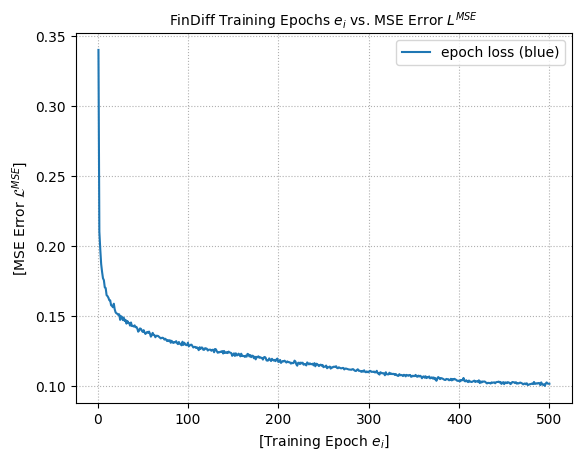

In [ ]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

# add grid
ax.grid(linestyle='dotted')

# plot the training epochs vs. the epochs' classification error
ax.plot(np.array(range(1, len(train_epoch_losses)+1)), train_epoch_losses, label='epoch loss (blue)')

# add axis legends
ax.set_xlabel('[Training Epoch $e_i$]', fontsize=10)
ax.set_ylabel('[MSE Error $\mathcal{L}^{MSE}$]', fontsize=10)

# set plot legend
plt.legend(loc='upper right', numpoints=1, fancybox=True)

# add plot title
plt.title('FinDiff Training Epochs $e_i$ vs. MSE Error $L^{MSE}$', fontsize=10);

## Generate Data using the FinDiff model

Init and set sampling parameters.

Use FinDiff to generate new data samples.

In [ ]:
# init samples to be generated
samples = torch.randn((len(label_torch), encoded_dim), device=device)

# init the generation progress bar
pbar = tqdm(iterable=reversed(range(0, diffusion_steps)), position=0, leave=True)

with torch.no_grad():
  # iterate over diffusion steps
  for diffusion_step in pbar:

      # prepare and set training epoch progress bar update
      now = datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')
      pbar.set_description('[LOG {}] Diffusion Step: {}'.format(str(now), str(diffusion_step).zfill(4)))

      # init diffusion timesteps
      timesteps = torch.full((len(label_torch),), diffusion_step, dtype=torch.long, device=device)

      # run synthesizer model forward pass
      model_out = synthesizer_model(x=samples.float(), timesteps=timesteps, label=label_torch.to(device))

      # run diffuser model forward pass
      samples = diffuser_model.p_sample_gauss(model_out, samples, timesteps)


[LOG 2025-05-24 15:16:02] Diffusion Step: 0000: : 500it [1:05:17,  7.84s/it]


Decode generated FinDiff samples.

In [ ]:
# split sample into numeric and categorical parts
samples = samples.detach().cpu().numpy()
samples_num = samples[:, cat_dim:]
samples_cat = samples[:, :cat_dim]

# denormalize numeric attributes
z_norm_upscaled = num_scaler.inverse_transform(samples_num)
z_norm_df = pd.DataFrame(z_norm_upscaled, columns=num_attrs)

# get embedding lookup matrix
embedding_lookup = synthesizer_model.get_embeddings().cpu()

# reshape back to batch_size * n_dim_cat * cat_emb_dim
samples_cat = samples_cat.reshape(-1, len(cat_attrs), cat_emb_dim)

# compute pairwise distances
distances = torch.cdist(x1=embedding_lookup, x2=torch.Tensor(samples_cat))

# get the closest distance based on the embeddings that belong to a column category
z_cat_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

nearest_dist_df = pd.DataFrame(index=range(len(samples_cat)), columns=cat_attrs)

# iterate over categorical attributes
for attr_idx, attr_name in enumerate(cat_attrs):

    attr_emb_idx = list(vocab_per_attr[attr_name])
    attr_distances = distances[:, attr_emb_idx, attr_idx]

    nearest_values, nearest_idx = torch.min(attr_distances, dim=1)
    nearest_idx = nearest_idx.cpu().numpy()

    z_cat_df[attr_name] = np.array(attr_emb_idx)[nearest_idx]  # need to map emb indices back to column indices
    nearest_dist_df[attr_name] = nearest_values.cpu().numpy()

z_cat_df = z_cat_df.apply(label_encoder.inverse_transform)

'''
Round off int and clip range
'''
#for x in int_attrs:
#    if x in z_norm_df.columns:
#        z_norm_df[x] = z_norm_df[x].round()
#        if 'PAY' in x:
#            z_norm_df[x] = z_norm_df[x].clip(lower=-1)
#        if x == 'EDUCATION':
#            z_norm_df[x] = z_norm_df[x].clip(lower=1, upper=4)

samples_decoded = pd.concat([z_cat_df, z_norm_df], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [ ]:
samples_decoded.head(10)

,fm,department_title,character_title,sub_obj_title,sector,transaction_amount
0,fm_9,department_title_22 HUMAN SERVICES,character_title_02 PURCHASE OF SERVICES,sub_obj_title_TRANSPORTATION 0211,sector_Transportation and Warehousing,644.597534
1,fm_10,department_title_10 MANAGING DIRECTOR,character_title_02 PURCHASE OF SERVICES,sub_obj_title_LEGAL SERVICES 0253,"sector_Professional, Scientific, and Technical...",261.643555
2,fm_1,department_title_10 MANAGING DIRECTOR,character_title_02 PURCHASE OF SERVICES,sub_obj_title_LEGAL SERVICES 0253,"sector_Professional, Scientific, and Technical...",1884.704834
3,fm_5,department_title_25 FLEET MANAGEMENT,character_title_02 PURCHASE OF SERVICES,sub_obj_title_RENTS 0285,sector_Wholesale Trade,4.013294
4,fm_5,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_FIRE FIGHTING AND SAFETY 0312,sector_Wholesale Trade,460.837677
5,fm_6,department_title_28 WATER,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_ELECTRICAL AND COMMUNICATION 0310,sector_Wholesale Trade,2721.763672
6,fm_8,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_MOTOR VEHICLE PARTS AND ACCESSOR...,sector_Wholesale Trade,109.523743
7,fm_5,department_title_25 FLEET MANAGEMENT,character_title_02 PURCHASE OF SERVICES,sub_obj_title_JANITORIAL SERVICES 0202,sector_Administrative and Support and Waste Ma...,158.268692
8,fm_8,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_MOTOR VEHICLE PARTS AND ACCESSOR...,sector_Wholesale Trade,13.141397
9,fm_6,department_title_14 HEALTH,character_title_02 PURCHASE OF SERVICES,sub_obj_title_PROF SRVSPRAYGROUNDS 0646P,sector_Administrative and Support and Waste Ma...,867.299744


## Evaluate the Generated Data

In [ ]:
samples_decoded.to_csv('phily_sector_findiff.csv')

import pickle

# Save the object to a pickle file
filename = 'phily_sector_findiff.pkl'
with open(filename, 'wb') as file:
    pickle.dump(synthesizer_model, file)

print(f"Object saved to {filename}")

Object saved to phily_sector_findiff.pkl


In [31]:
samples_decoded = pd.read_csv('/content/phily_sector_findiff.csv',  index_col = 0)
samples_decoded.head(10)

,fm,department_title,character_title,sub_obj_title,sector,transaction_amount
0,fm_9,department_title_22 HUMAN SERVICES,character_title_02 PURCHASE OF SERVICES,sub_obj_title_TRANSPORTATION 0211,sector_Transportation and Warehousing,644.597530
1,fm_10,department_title_10 MANAGING DIRECTOR,character_title_02 PURCHASE OF SERVICES,sub_obj_title_LEGAL SERVICES 0253,"sector_Professional, Scientific, and Technical...",261.643550
2,fm_1,department_title_10 MANAGING DIRECTOR,character_title_02 PURCHASE OF SERVICES,sub_obj_title_LEGAL SERVICES 0253,"sector_Professional, Scientific, and Technical...",1884.704800
3,fm_5,department_title_25 FLEET MANAGEMENT,character_title_02 PURCHASE OF SERVICES,sub_obj_title_RENTS 0285,sector_Wholesale Trade,4.013294
4,fm_5,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_FIRE FIGHTING AND SAFETY 0312,sector_Wholesale Trade,460.837680
5,fm_6,department_title_28 WATER,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_ELECTRICAL AND COMMUNICATION 0310,sector_Wholesale Trade,2721.763700
6,fm_8,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_MOTOR VEHICLE PARTS AND ACCESSOR...,sector_Wholesale Trade,109.523740
7,fm_5,department_title_25 FLEET MANAGEMENT,character_title_02 PURCHASE OF SERVICES,sub_obj_title_JANITORIAL SERVICES 0202,sector_Administrative and Support and Waste Ma...,158.268690
8,fm_8,department_title_25 FLEET MANAGEMENT,character_title_03 MATERIALS AND SUPPLIES,sub_obj_title_MOTOR VEHICLE PARTS AND ACCESSOR...,sector_Wholesale Trade,13.141397
9,fm_6,department_title_14 HEALTH,character_title_02 PURCHASE OF SERVICES,sub_obj_title_PROF SRVSPRAYGROUNDS 0646P,sector_Administrative and Support and Waste Ma...,867.299740


In [52]:
# build a metadata for evaluation (from SDV)
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=train)

# generate quality report
quality_report = sdv_st.evaluate_quality(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 22.40it/s]|
Column Shapes Score: 96.72%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 19.77it/s]|
Column Pair Trends Score: 92.74%

Overall Score (Average): 94.73%



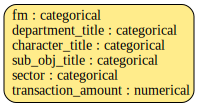

In [53]:
metadata.visualize()

In [54]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,fm,TVComplement,0.99243
1,department_title,TVComplement,0.93967
2,character_title,TVComplement,0.99614
3,sub_obj_title,TVComplement,0.90277
4,sector,TVComplement,0.98403
5,transaction_amount,KSComplement,0.98798


In [55]:
# plot Column Shapes -> referred to the "Fidelity Column" in the paper
fig = quality_report.get_visualization(property_name='Column Shapes')
fig.show()

In [56]:
# plot Column Pair Trends -> referred to the "Fidelity Row" in the paper
fig = quality_report.get_visualization(property_name='Column Pair Trends')
fig.show()

In [57]:
import sdv

for col in num_attrs:
  quality_report = sdv.evaluation.single_table.evaluate_quality(train, samples_decoded, metadata)
  fig = sdv.evaluation.single_table.get_column_plot(
      real_data=train,
      synthetic_data=samples_decoded,
      metadata=metadata,
      column_name=col
  )

  fig.show()

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 6/6 [00:00<00:00, 22.49it/s]|
Column Shapes Score: 96.72%

(2/2) Evaluating Column Pair Trends: |██████████| 15/15 [00:00<00:00, 18.86it/s]|
Column Pair Trends Score: 92.77%

Overall Score (Average): 94.75%



In [58]:
from sdmetrics.single_column import BoundaryAdherence
from sdmetrics.single_column import RangeCoverage

for i in num_attrs:
    print(i +  " " +
    str(BoundaryAdherence.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    ))
       + ", RangeCoverage  " +
          str(RangeCoverage.compute(
              real_data=train[i],
        synthetic_data=samples_decoded[i]
          )) )

transaction_amount 1.0, RangeCoverage  0.7144433629269203


In [59]:
from sdmetrics.single_column import CategoryAdherence
from sdmetrics.single_column import CategoryCoverage

for i in cat_attrs:
    print(i +  " CategoryAdherence" +
    str(CategoryAdherence.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    ))
    + ", CategoryCoverage : " + str(CategoryCoverage.compute(
        real_data=train[i],
        synthetic_data=samples_decoded[i]
    )))


fm CategoryAdherence1.0, CategoryCoverage : 1.0
department_title CategoryAdherence1.0, CategoryCoverage : 1.0
character_title CategoryAdherence1.0, CategoryCoverage : 1.0
sub_obj_title CategoryAdherence1.0, CategoryCoverage : 0.9950980392156863
sector CategoryAdherence1.0, CategoryCoverage : 1.0


In [60]:
from sklearn.model_selection import train_test_split


test = train_cleaned[cat_attrs+num_attrs].copy()
test = test[~test.index.isin(train.index)]
# convert categorical attributes to string
#test[cat_attrs] = test[cat_attrs].astype(str)

for cat in cat_attrs:
    test[cat] = cat + '_' + test[cat].astype(str)
    test = test[test[cat].isin(train[cat].unique())]
test = test.sample(n=30000, random_state=42)

In [61]:
'''
Compute Utility Score
'''
from sdmetrics.single_table import  LinearRegression

test_synthetic = test.copy()
for cat in cat_attrs:
    test_synthetic = test_synthetic[test_synthetic[cat].isin(samples_decoded[cat].unique())]
missed_cat_penalty =  test_synthetic.shape[0]/test.shape[0]

synthetic_data_r2 = LinearRegression.compute(
    test_data=test,
    train_data=samples_decoded,
    target='transaction_amount',
    metadata=metadata.to_dict()
)

real_data_r2 = LinearRegression.compute(
    test_data=test,
    train_data=train,
    target='transaction_amount',
    metadata=metadata.to_dict()
)

print(f'Utility Score: {min(synthetic_data_r2/real_data_r2 , 1)*missed_cat_penalty}')

Utility Score: 0.7169151474562813


In [64]:
synthetic_data_r2

0.1016093559934339

In [65]:
real_data_r2

0.1417313560104827

In [62]:
from sdmetrics.single_table import DCRBaselineProtection

privacy = DCRBaselineProtection.compute_breakdown(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata.to_dict(),
    num_rows_subsample = 100,
    num_iterations =50
)
print(f'Privacy Score: {privacy["score"]}')

Privacy Score: 0.35326657577262294


In [63]:
from sdmetrics.single_table import NewRowSynthesis

NewRowSynthesis.compute(
    real_data=train,
    synthetic_data=samples_decoded,
    metadata=metadata.to_dict(),
    numerical_match_tolerance=0.01,
    synthetic_sample_size=3000
)

0.7606666666666667